# Housing Prices Prediction
## Problem Statement
> **Can we use machine learning to help prospective home buyers and sellers in King County evaluate the market value of a house?**

### Problem Understanding
Typically in the process of buying or selling a house, a home owner would hire a real estate agent to make an appraisal of the market value of a house. This appraisal then helps them decide on the best listing price of a property. Such valuations would typically be based on certain factors like the size of the house, and other indicators of value like pools, and garages.

#### King County 
![](https://www.mapsofworld.com/usa/states/washington/maps/king-wa-county-map.jpg)
King County is located in the US State of Washington. It is on the west coast of the US. 

Key Geographical Parts of King County Include:
- City of Seattle (largest city in Washington)
- Lake Washington (largest lake in KC)
- Lake Sammamish
- Lake Union 
- Airports (located in the middle and south part of KC)
- Cascade Range (a series of mountains on the east side of King County)
- Vashon Island (connected to West Seattle)
- Mercer Island

Hence our objectives would be to:
- create a model that can supplement a real estate appraisal to help home buyers/sellers in King County make better decisions
- extract insights as to how important different factors affect housing prices in King County.
## Evaluation Metrics
### Mean Absolute Error
Mean absolute error is defined by 
$$
MAE = \frac{\sum^n_{i=1}|y_i-\hat{y}_i|}{n}
$$
where $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value of $y_i$. $n$ is the total number of examples evaluated.

We choose MAE as our primary evaluation metric because it is directly interpretable as the average error of our model, and since it does not square our error, it does not heavily penalize our model when there are extreme outliers (i.e. it tells how our model performs on typical data)
### Benchmark
While the US does not appear to set any margin of error for a real estate appraisal, UK case law says that the margin of error of the appraised value from the actual value should not generally exceed 15%. The typical margin of error is 5% for simple residential property valuations.

Hence, for our model to be reliable, we would expect a margin of error of less than 15% from the actual value. One way to interpret this would be a Mean Absolute Percentage Error of less than 15%. 

## Importing Libraries

In [2]:
# !pip install scikit-learn -U # for google colab

     |████████████████████████████████| 22.3MB 1.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()


# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve
from statsmodels.api import qqplot
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV, validation_curve, RandomizedSearchCV


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, VarianceThreshold, mutual_info_regression, RFE

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Utility Functions
To help in our analysis, we will create several functions.

- Plot Learning Curve: Generates a learning curve. This is a plot of the training and cross validation scroes, of the model when it is fitted with the subset of the data. It describes how the model performance improves as it gets more data. I will use it to analyze the bias and variance of the various learning algorithms tested
- Outlier Detection: Uses Tukey's Fences to Detect Outliers. 

In [142]:
def plot_learning_curve(model, X, y, scoring, cv = KFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 5)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

def plot_validation_curve(model, X, y, param_name, param_range, scoring="neg_mean_absolute_error", cv=KFold(shuffle=True, random_state = 42)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_scores, test_scores = validation_curve(model, X, y, param_name = param_name, param_range = param_range, scoring=scoring, n_jobs = -1)
  scores = pd.DataFrame({
      "Param Range" : np.tile(param_range, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Param Range"])
  
  sns.lineplot(data=scores, x="Param Range", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Validation Curve of {model_name} ({param_name})")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel(f"{param_name}")
  return fig

def outlierDetection(df, var, sort = True, deskew=True):
    """
    Utilty function for detecting basic outliers. Prints out no. of outliers, shows first 5 outliers and displays a box plot. Outliers are defined in this case by Tukey's fences, where outliers are data points above or below the upper or lower quantiles by 1.5 * IQR.

    Parameters:
        df = DataFrame to detect outliers in
        var = name of column where outlier detection is performed
        sort = should the returned dataset be sorted?
    Returns:
        Dataset which only includes outliers
    """
    if deskew:
      col = df[var].apply(np.log)
    else:
      col = df[var]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        display(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.boxplot(y = var,data = df, orient= "h")
    sns.despine(left = True)
    plt.title(f"Box Plot of {var}")
    plt.show()
    if sort:
        return outlier_df.sort_values(var)
    else:
        return outlier_df


def cat_plot(df, features, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        # counts = df[feature].value_counts()
        sns.countplot(data = df, y = feature, ax = ax[idx])
    return fig

## Data Ingestion
We start by loading the data set into a Pandas dataframe. 
We then take a look at what our data looks like.

In [6]:
house_df = pd.read_csv("kc_house_data.csv")
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We immediately notice a few things:
- rows are shuffled, as they are neither ordered by id or date 
- id is completely meaningless, and can be dropped
- the data type for date seems to be wrong
- floors appears to be a float instead of an integer

## Data Exploration
To understand our data better, we will perform an exploratory data analysis. This will help inform our future decisions later on.
### Dataset Description
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. 

### Dataset Dictionary
We start our EDA by getting an understanding of what each column means. The description of each column is obtained from the King Country government website.

Link: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#agla

| Column | Data Type | Remarks |
|---|---|---|
| id | Integer (Nominal) | Unique ID for each house |
| date | Date | Need to convert to dt format from string |
| price | Float (Continuous) | Target Variable. Price of House in USD |
| bedrooms | Integer (Discrete) | No. of Bedrooms in the House |
| bathrooms | Float (Discrete) | Quarter of a bathroom is a bathroom with a toilet only, no shower |
| sqft_living | Float (Continuous) | Square footage of the inside of the house |
| sqft_lot | Float (Continuous) | Square footage of the entire home, including the exterior |
| floors | Float (Discrete) | Includes split level home|
| waterfront | Integer (Boolean) | Is the property a waterfront property? |
| view | Integer (Ordinal) | On a scale of 0 to 4, how good is the view of the property |
| condition | Integer (Ordinal) | On a scale of 1 to 5, how good is the condition of the house  |
| grade | Integer (Ordinal) | On a scale of 1 to 13, how good is the quality of the house |
| sqft_above | Float (Continuous) | 	The living area in a house not including the basement. |
| sqft_basement | Float (Continuous) | Square footage of the basement of the house |
| yr_built | Integer (Discrete) | Year of Construction |
| yr_renovated | Integer (Discrete) | Year of latest renovation |
| zipcode | Integer (Nominal) | zipcode of house |
| lat | Float (Continuous) | Latitude (North-South)|
| long | Float (Continuous) | Longitude (East-West)|
| sqft_living15 | Float (Continuous)|Average Sqft_Living for nearest 15 houses |
| sqft_lot15 | Float (Continuous) | Average Sqft_lot for nearest 15 houses |

Also from the King County Government website, we obtain information on the Condition and Grade features
#### Condition
Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

#### Grade 
Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

Now that we have a better understanding of the meaning of our features, we will begin our EDA
### Objectives for EDA
- How many rows and how many columns are there?
- What does the target variable look like?
- What is the distribution of the numerical columns?
- What is the distribution of the categorical columns?
- Are there any missing values and how many of them are there?
- Are there any outliers in the data?
- How are the various columns correlated to the target variable?


In [7]:
house_eda = house_df.copy() # Make a copy the dataframe to do eda on

### Univariate Analysis
We will start with a univariate analysis. Our objective here is to determine the distribution of each feature, and see if there are any outliers. We will also check if there are any mistakes in the data.

#### Descriptive Analysis

In [8]:
house_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

- There are 21613 rows and 21 columns.
- There appear to be no missing values in the data.
- `date` has an incorrect data type. It should be represented as a date instead of a string. Hence, we will convert the feature from a string to a datetime object.

In [9]:
house_eda["date"] = pd.to_datetime(house_eda["date"]) 

In [10]:
house_eda.describe().round(4)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.0000,21613.0000,21613.0000,2.161300e+04,21613.0000,21613.0000,21613.0000,21613.0000,21613.0000,21613.0000,21613.000,21613.0000,21613.0000,21613.0000,21613.0000,21613.0000,21613.0000,21613.0000
mean,4.580302e+09,5.400881e+05,3.3708,2.1148,2079.8997,1.510697e+04,1.4943,0.0075,0.2343,3.4094,7.6569,1788.3907,291.509,1971.0051,84.4023,98077.9398,47.5601,-122.2139,1986.5525,12768.4557
std,2.876566e+09,3.671272e+05,0.9301,0.7702,918.4409,4.142051e+04,0.5400,0.0865,0.7663,0.6507,1.1755,828.0910,442.575,29.3734,401.6792,53.5050,0.1386,0.1408,685.3913,27304.1796
min,1.000102e+06,7.500000e+04,0.0000,0.0000,290.0000,5.200000e+02,1.0000,0.0000,0.0000,1.0000,1.0000,290.0000,0.000,1900.0000,0.0000,98001.0000,47.1559,-122.5190,399.0000,651.0000
25%,2.123049e+09,3.219500e+05,3.0000,1.7500,1427.0000,5.040000e+03,1.0000,0.0000,0.0000,3.0000,7.0000,1190.0000,0.000,1951.0000,0.0000,98033.0000,47.4710,-122.3280,1490.0000,5100.0000
50%,3.904930e+09,4.500000e+05,3.0000,2.2500,1910.0000,7.618000e+03,1.5000,0.0000,0.0000,3.0000,7.0000,1560.0000,0.000,1975.0000,0.0000,98065.0000,47.5718,-122.2300,1840.0000,7620.0000
75%,7.308900e+09,6.450000e+05,4.0000,2.5000,2550.0000,1.068800e+04,2.0000,0.0000,0.0000,4.0000,8.0000,2210.0000,560.000,1997.0000,0.0000,98118.0000,47.6780,-122.1250,2360.0000,10083.0000
max,9.900000e+09,7.700000e+06,33.0000,8.0000,13540.0000,1.651359e+06,3.5000,1.0000,4.0000,5.0000,13.0000,9410.0000,4820.000,2015.0000,2015.0000,98199.0000,47.7776,-121.3150,6210.0000,871200.0000


- Housing Prices are likely to be positively skewed with many outliers, as the max price of the houses is much larger than the upper quartile.
- Similarly, living space and lot space also has a positively skewed distribution.
- Most houses are not waterfront properties (at least 75%)
- Most houses have 0 basement space. 
- At least 75% of houses have never been renovated.
- The minimum value of bedrooms, bathrooms is 0. This suggests the presence of extreme outliers in the data.

#### Target Variable
The target variable we are trying to predict is the price in USD of the house.

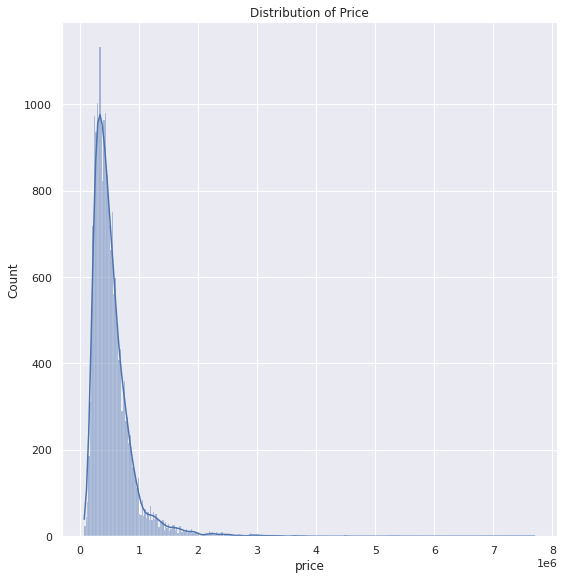

In [11]:
sns.displot(data=house_eda, x="price", kde=True, height = 8)
plt.title("Distribution of Price")
plt.show()

We note that the distribution of the price is heavily positively skewed. Most houses are less than $100K USD, but some houses cost more than a million. This suggests that the mean and standard deviation of the price might not be the best descriptor of it's distribution.

In [15]:
price_median = house_eda["price"].median() 
price_iqr = house_eda["price"].quantile(.75) - house_eda["price"].quantile(.25) 
print(f"Median Price: ${price_median}, Price IQR: ${price_iqr}")

Median Price: $450000.0, Price IQR: $323050.0


When looking at the median price, we note that while it is still quite high, the prices are more reasonable.

We attempt to see what happens when a log transformation is applied on the data, in an attempt to deskew it.

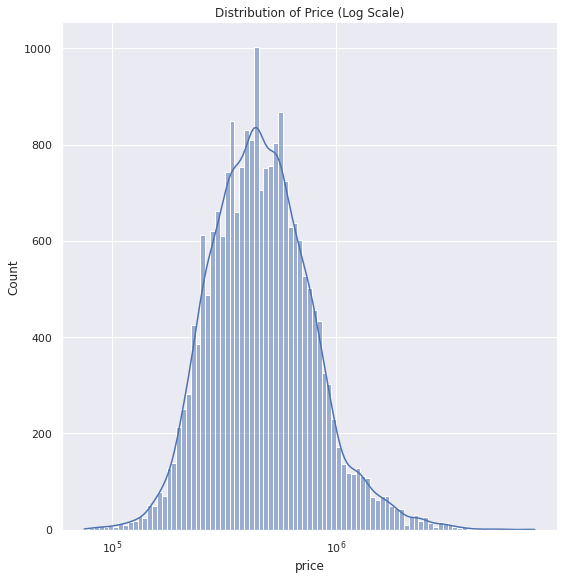

In [16]:
sns.displot(data=house_eda, x="price", kde=True, log_scale=True,height = 8)
plt.title("Distribution of Price (Log Scale)")
plt.show()

When plotted on a log scale, the prices appear to follow a normal distribution. This suggests that prices in King County follow a log normal distribution, suggesting that transformation of the target variable to accurately reflect this might improve the performance of the model.

#### Quantitative Features

In [18]:
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'lat', 'long']

We generate histograms of all the quantitative features to get a clear look at what their distributions look like.

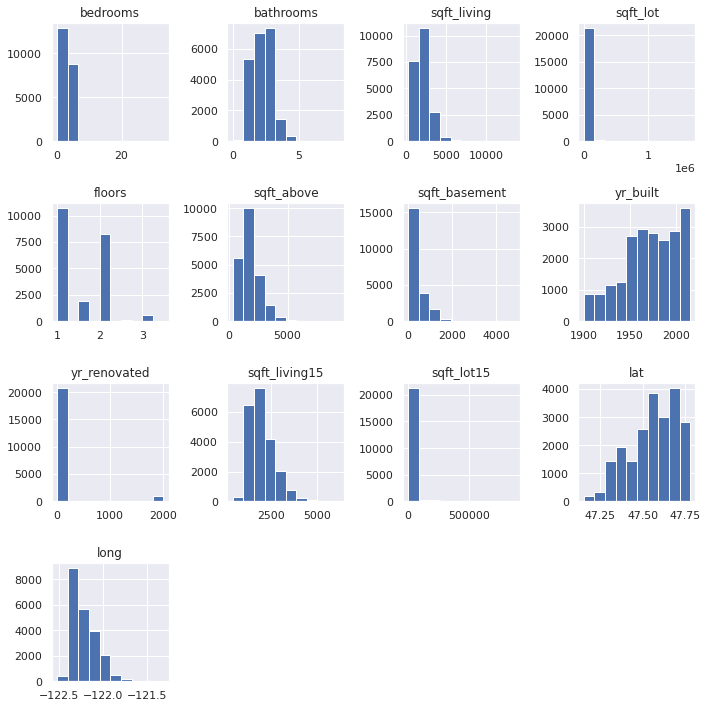

In [19]:
house_eda[numerical_features].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

Based on the histograms, we see that
- Living area appears to be positively skewed
- Most houses have never been renovated, as suggested by most having a year of 0 (a prefilled indicator value)
- Most houses were constructed after 1950
- Most houses have very similar and small lot sizes. 

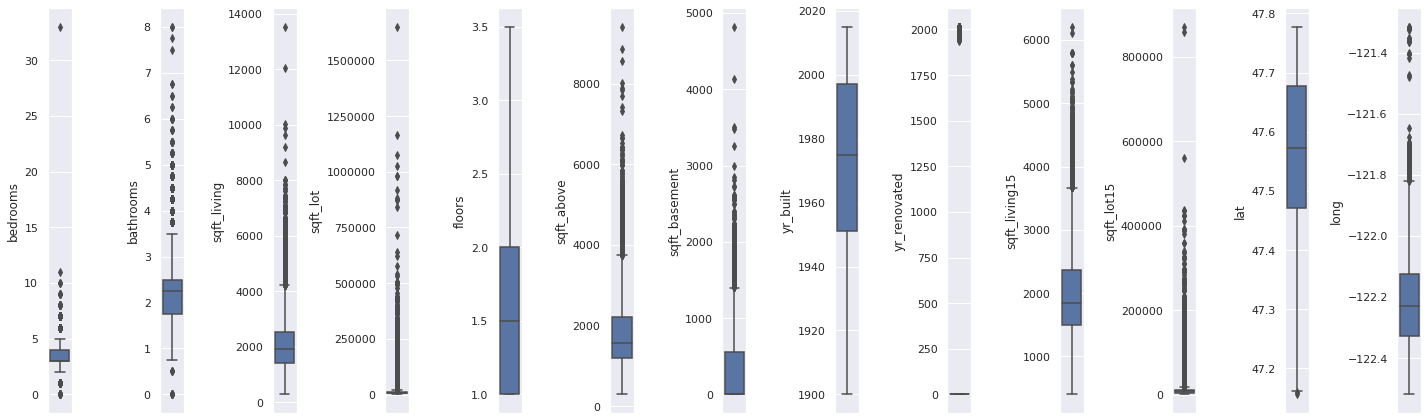

In [20]:
fig, ax = plt.subplots(1, len(numerical_features), figsize=(20, 6), tight_layout = True)

for idx, col in enumerate(numerical_features):
    ax[idx].ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    sns.boxplot(data = house_eda, y=col, ax = ax[idx])
fig.show()

From the boxplots we note that
- The distribution of sqft_living and sqft_above is very similar. Based of the data set description, this is likely because both report very similar areas, jus that sqft_above reports the basement area as well.
- There is one extreme outlier house with more than 30 bedrooms. 
- Similarly, there are houses with no bedrooms and no bathrooms.
- While most houses have low lot sizes, a few have extremely large lot sizes, presumably located in more rural areas, but this will have to be investigated further.

We want to investigate values of discrete data further. To do this, we will generate count plots of the data. In addition, we will also extract the number of full bathrooms and toilets only from each house (0.25 of a bathroom is counted as a toilet with no attached shower)

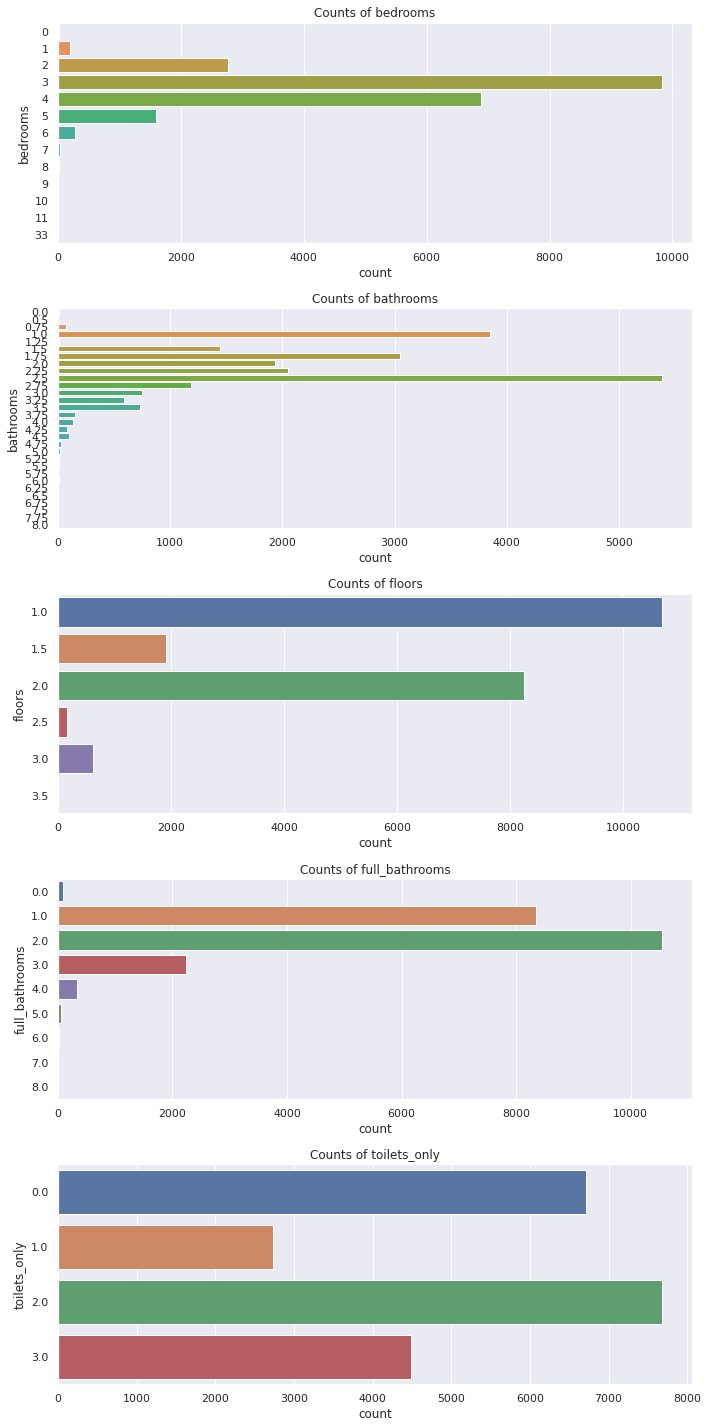

In [30]:
house_eda["full_bathrooms"] = house_eda["bathrooms"].apply(lambda x : np.floor(x))
house_eda["toilets_only"] = (house_eda["bathrooms"] - house_eda["full_bathrooms"]) / 0.25
count_data = ["bedrooms", "bathrooms", "floors", "full_bathrooms", "toilets_only"]
fig = cat_plot(house_eda, count_data)

Most houses have:
- 3 Bedrooms
- 2 Full Bathrooms (shower)
- 2 Toilets
- 1 Floor

We note that some houses are split level properties.

Strangely we also see a few houses apparently have zero bedrooms and zero bathrooms. This is suspect, and should be investigated.

#### Qualitative Features
We continue by investigating the categorical features in the dataset. These features are ordinally valued, hence they can be treated as discrete columns. This means that no one hot encoding is required for the features to be properly interpreted.

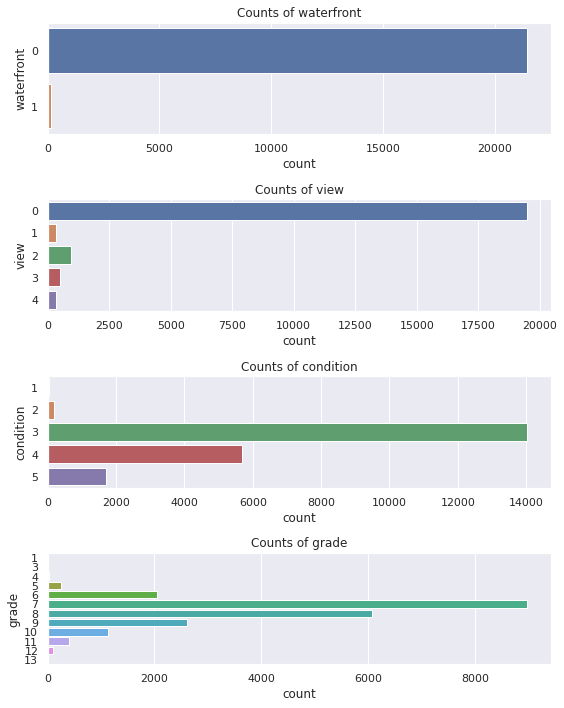

In [17]:
categorical_features = ['waterfront', 'view', 'condition', 'grade']
fig = cat_plot(house_eda, categorical_features, figsize=(8, 10))

Most houses:
- are not waterfront properties (situated next to a Lake or river)
- have no view at all
- are of average condition
- have a grade of 7 (average quality)

#### Time Series Features
We also will investigate the features derived from the date of sale.

In [31]:
house_eda["month"] = house_eda["date"].dt.month

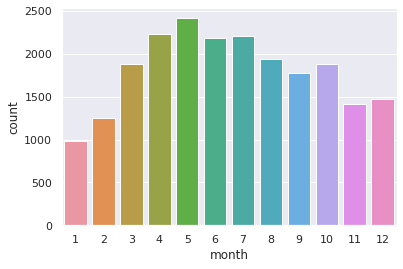

In [19]:
sns.countplot(x="month", data=house_eda)

Most houses are sold between April (4th month) and August (8th Month). The least houses are sold in January and Feburary. Since the data only spans a single year's worth of sales, it may not be representative of the actual trend.

We can calculate the age of a property based off it's year of construction and sale year. 

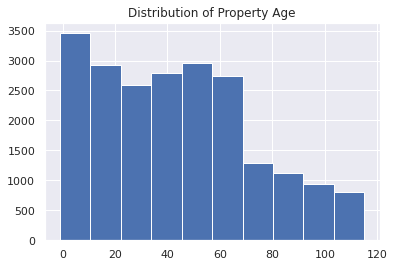

In [32]:
house_eda["age"] = house_eda["date"].dt.year - house_eda["yr_built"]
house_eda["age"].hist()
plt.title("Distribution of Property Age")
plt.show()


Most houses are between 20 and 60 years of age. The distribution of age is positively skewed, with a few houses being very old (>100 years old)

#### Investigating Outliers & Anomalies
During our EDA, we noted that many features had outlier data, which must be investigated. The reason is that we need to perform data cleaning to ensure that our model is able to have an accurate prediction and having too many outliers may severly impact our model's ability to learn and our ability to evaluate the model. 

Given that our distributions are heavily skewed, we will first apply a log transformation to deskew our data, before using Tukey's Fences to detect outliers.

We begin by attempting to determine which features have the most outliers. 

In [ ]:
no_of_outliers = []
for feature in numerical_features:
  no_of_outliers.append(len(outlierDetection(house_eda, feature)))

In [25]:
pd.Series(no_of_outliers, index=numerical_features).sort_values()

floors              0
sqft_basement       0
yr_built            0
yr_renovated        0
long                0
lat                 2
sqft_above         53
sqft_living15      78
sqft_living       110
bedrooms          274
sqft_lot15       2492
sqft_lot         2555
bathrooms        4125
dtype: int64

We see that the main source of outliers is the number of bathrooms, followed by lot size and the number of bedrooms.

We start by investigating those properties which are an outlier in terms of their number of bathrooms.

Outliers in Series (First 5)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
5,7237550310,2014-05-12,1225000.0,4,4.5,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
8,2414600126,2015-04-15,229500.0,3,1.0,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
11,9212900260,2014-05-27,468000.0,2,1.0,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000


No. of Outliers: 4125


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


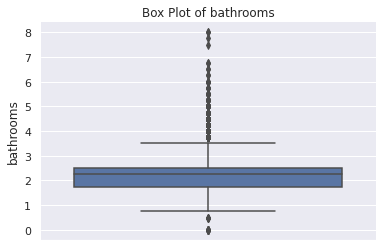

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10481,203100435,2014-09-18,484000.0,1,0.00,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
14423,9543000205,2015-04-13,139950.0,0,0.00,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,3980300371,2014-09-26,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024,9175600025,2014-10-07,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
8546,424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
9254,9208900037,2014-09-19,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
7252,6762700020,2014-10-13,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800


In [26]:
outliers_bath = outlierDetection(house_eda, "bathrooms")
outliers_bath.sort_values("bathrooms")

We see that there are houses with many bathrooms (up to 8). Judging by their Grade of 13 and 12, these houses are likely luxury mansions (as pointed out in the King County assessor glossary, Grades 13 and 12 are reserved for high end properties).

On the other hand, there are also properties with no bathrooms at all. However, we note that some of them have an average grade, which does not appear to make any sense.

We continue by investigating the lot sizes of the houses.

Outliers in Series (First 5)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
21,2524049179,2014-08-26,2000000.0,3,2.75,3050,44867,1.0,0,4,3,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336
27,3303700376,2014-12-01,667000.0,3,1.00,1400,1581,1.5,0,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,1860,3861
31,2426039314,2014-12-01,280000.0,2,1.50,1190,1265,3.0,0,0,3,7,1190,0,2005,0,98133,47.7274,-122.357,1390,1756
36,9435300030,2014-05-28,550000.0,4,1.00,1660,34848,1.0,0,0,1,5,930,730,1933,0,98052,47.6621,-122.132,2160,11467


No. of Outliers: 2555


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


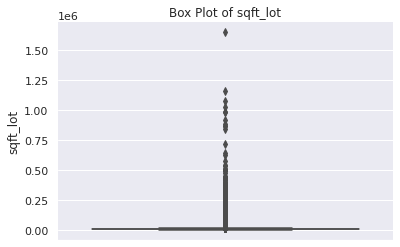

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15743,9828702895,2014-10-22,700000.0,4,1.75,2420,520,1.5,0,0,3,7,2420,0,1900,0,98112,47.6209,-122.302,1200,1170
5826,1773101159,2015-01-07,250000.0,3,2.25,1050,572,2.0,0,0,3,7,740,310,2006,0,98106,47.5549,-122.363,1260,1062
7589,6371000026,2015-01-22,367500.0,2,2.00,1030,600,2.0,0,0,3,8,680,350,2004,0,98116,47.5788,-122.410,1120,1267
3452,2559950110,2015-04-22,1234570.0,2,2.50,2470,609,3.0,0,0,3,11,1910,560,2011,0,98112,47.6182,-122.312,2440,1229
20604,7899800857,2014-12-15,256950.0,2,2.00,1070,635,2.0,0,0,3,9,720,350,2008,0,98106,47.5212,-122.357,1070,928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,722069232,2014-09-05,998000.0,4,3.25,3770,982998,2.0,0,0,3,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141
7769,2323089009,2015-01-19,855000.0,4,3.50,4030,1024068,2.0,0,0,3,10,4030,0,2006,0,98045,47.4619,-121.744,1830,11700
7647,2623069031,2014-05-21,542500.0,5,3.25,3010,1074218,1.5,0,0,5,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825
17319,3326079016,2015-05-04,190000.0,2,1.00,710,1164794,1.0,0,0,2,5,710,0,1915,0,98014,47.6888,-121.909,1680,16730


In [23]:
outliers_lotsize = outlierDetection(house_eda, "sqft_lot")
outliers_lotsize.sort_values("sqft_lot")

We note the presence of certain homes with a very large lot size. The largest lot, when cross referenced with Google Maps, appears to represent a rural farm property. 

We continue by investigating the number of bedrooms per house

Outliers in Series (First 5)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
154,7920100045,2014-05-16,350000.0,1,1.00,700,5100,1.0,0,0,3,7,700,0,1942,0,98115,47.6790,-122.300,1010,5100
264,2123039032,2014-10-27,369900.0,1,0.75,760,10079,1.0,1,4,5,5,760,0,1936,0,98070,47.4683,-122.438,1230,14267
350,7325600160,2014-06-04,299000.0,1,0.75,560,12120,1.0,0,0,3,4,560,0,1967,0,98014,47.6750,-121.854,1300,19207
465,8658300340,2014-05-23,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
556,5486800070,2014-06-20,1950000.0,7,3.50,4640,15235,2.0,0,1,3,11,2860,1780,1965,2003,98040,47.5666,-122.231,3230,20697


No. of Outliers: 274


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


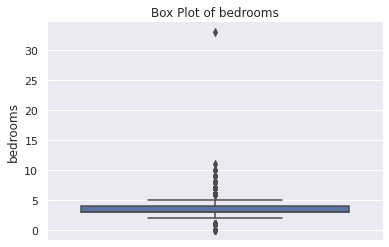

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
14423,9543000205,2015-04-13,139950.0,0,0.00,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
13314,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
19254,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745
8757,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960


In [27]:
outliers_bed = outlierDetection(house_eda, "bedrooms")
outliers_bed.sort_values("bedrooms")

When investigating, we found some strange occurances:
- House (id=2402100895) has 33 bedrooms, but only 1470sqft of living space. This seems to be impossible, especially given that the home has only 1 floor.
- There as a house with no bedrooms, and yet sells for over a million dollars


Finally, we investigate price outliers in our data

Outliers in Series (First 5)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_bathrooms,toilets_only,month,age
21,2524049179,2014-08-26,2000000.0,3,2.75,3050,44867,1.0,0,4,3,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336,2.0,3.0,8,46
153,7855801670,2015-04-01,2250000.0,4,3.25,5180,19850,2.0,0,3,3,12,3540,1640,2006,0,98006,47.5620,-122.162,3160,9750,3.0,1.0,4,9
246,2025069065,2014-09-29,2400000.0,4,2.50,3650,8354,1.0,1,4,3,9,1830,1820,2000,0,98074,47.6338,-122.072,3120,18841,2.0,2.0,9,14
269,7960900060,2015-05-04,2900000.0,4,3.25,5050,20100,1.5,0,2,3,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060,3.0,1.0,5,33
282,7424700045,2015-05-13,2050000.0,5,3.00,3830,8480,2.0,0,1,5,9,2630,1200,1905,1994,98122,47.6166,-122.287,3050,7556,3.0,0.0,5,110


No. of Outliers: 333


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


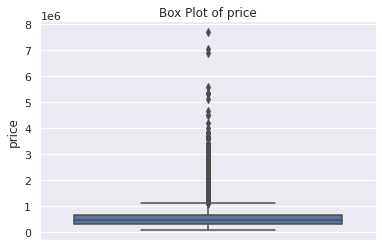

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_bathrooms,toilets_only,month,age
1149,3421079032,2015-02-17,75000.0,1,0.00,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882,0.0,0.0,2,49
15293,40000362,2014-05-06,78000.0,2,1.00,780,16344,1.0,0,0,1,5,780,0,1942,0,98168,47.4739,-122.280,1700,10387,1.0,0.0,5,72
465,8658300340,2014-05-23,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500,0.0,3.0,5,102
16198,3028200080,2015-03-24,81000.0,2,1.00,730,9975,1.0,0,0,1,5,730,0,1943,0,98168,47.4808,-122.315,860,9000,1.0,0.0,3,72
8274,3883800011,2014-11-05,82000.0,3,1.00,860,10426,1.0,0,0,3,6,860,0,1954,0,98146,47.4987,-122.341,1140,11250,1.0,0.0,11,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,8907500070,2015-04-13,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,5.0,0.0,4,6
4411,2470100110,2014-08-04,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,5.0,3.0,8,13
9254,9208900037,2014-09-19,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,7.0,3.0,9,13
3914,9808700762,2014-06-11,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,4.0,2.0,6,74


In [66]:
outliers_usd = outlierDetection(house_eda, "price")
outliers_usd.sort_values("price")

- We see that there are properties with multi million dollar prices. These are houses with a grade of 13 to 11 (considered luxury houses by the Data Set Glossary)

In conclusion, we note that there are many outliers in our data. 

### Bivariate Analysis
We now want to move on and investigate the relationships between the variables in our data.

In [35]:
house_corr = house_eda.drop(['id', 'zipcode', 'date', "full_bathrooms", "toilets_only", "age", "month"], axis=1).corr() # generate a correlation matrix. we dont generate correlation for features we dont intend to use at all

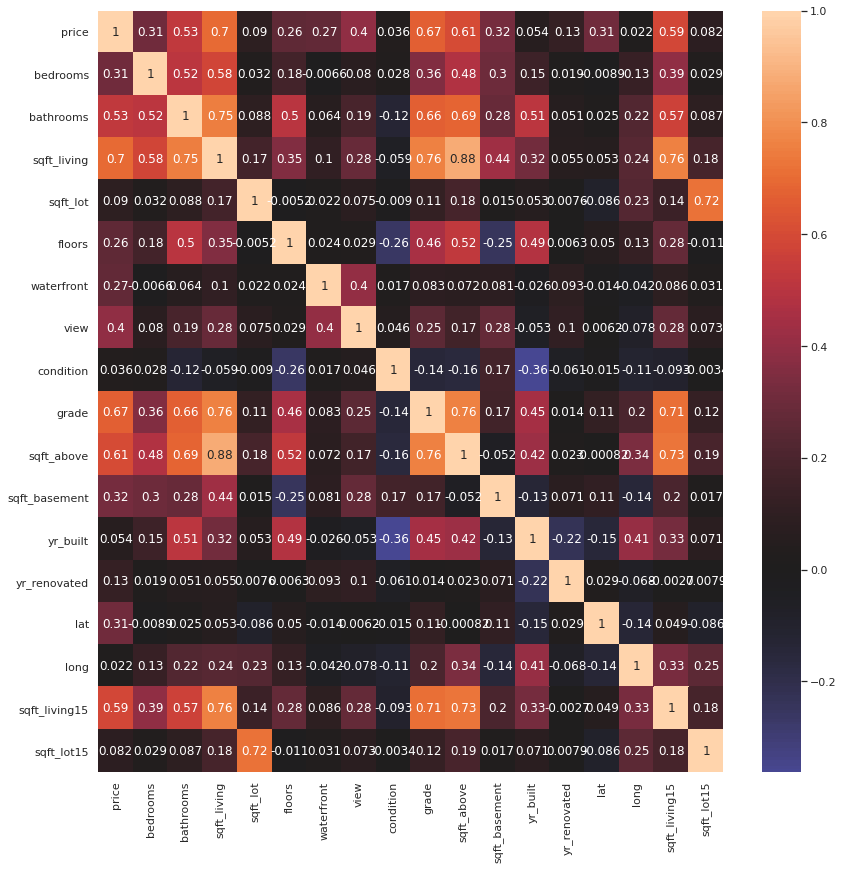

In [37]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(house_corr, ax = ax, annot = True, center = 0)
fig.show()

From the correlation plot, we note:
- The most correlated feature with housing prices (based of correlation), is the living area of the house. 
- The second most correlated feature with the housing prices is the grade of the house. This does make sense, as grade is an overall measure of the quality of the house. Unfortunately, it also means that grade also has high correlation with other features as well
- Sqft_above has a high correlation with sqft_living. As we have seen in prior research, this is largely because they measure almost the same area of the house. 
- Sqft_living15 has high correlation with sqft_living. This is likely because houses close to each other tend to have similar areas.

Hence, it may be wise to drop sqft_living15, sqft_lot15 and sqft_above as they are largely redundant.

#### What are the features most correlated with price?

In [38]:
house_corr.abs().sort_values("price", ascending=False)["price"]

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
Name: price, dtype: float64

We note that the extent of the living area has the highest correlation with price, followed by grade, area of the house with the exclusion of the basement.

#### What is the extent of multicolinearity in the data?
We note from our correlation plot that some features are correlated with each other. To measure which features suffer from multicolinearity the most, we will calculate the Variance Inflation Factor of each variable. 

The formula for VIF as as follows.
$$
VIF_i = \frac{1}{1-R_i^2}
$$

We can calculate the VIF by taking diagonal elements of the inverse correlation matrix of our dataset.

In [28]:
VIF_Vec = np.linalg.inv(house_corr.values).diagonal()
vif = pd.DataFrame({"VIF":VIF_Vec}, index=house_corr.columns)
vif.sort_values("VIF", ascending=False).style.format("{:.2f}")

,VIF
grade,3.73
bathrooms,3.38
price,3.29
sqft_living15,2.96
yr_built,2.52
sqft_lot15,2.14
sqft_lot,2.10
floors,1.99
bedrooms,1.67
long,1.51


We note that 
- Grade has the highest VIF. This is likely because grade is a overall measure of the quality of the house, which would take into account the other features of the house
- sqft_basement, sqft_above and sqft_living have overflowed values, suggesting they had extremely high VIF's. 

#### Geographical Analysis
We also want to get a better understanding of the geographical location of our houses. Hence, we use a scatter plot to plot the longitude and latitude, to understand where our houses are located.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


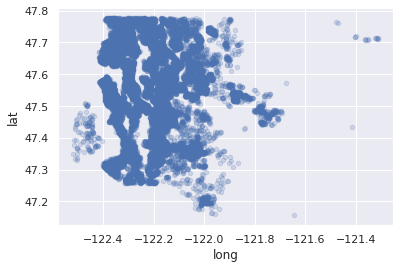

In [29]:
geographical_features = ["lat", "long"]
house_eda.plot(kind='scatter', x='long', y='lat', alpha=.2)
plt.show()

We see that most properties are in the more urbanised parts of King County (corresponding to Seattle, Renton, Kent)

Vashon Island is more rural in nature based on research, and hence has lower density of properties.

##### Which parts of the city have more value?

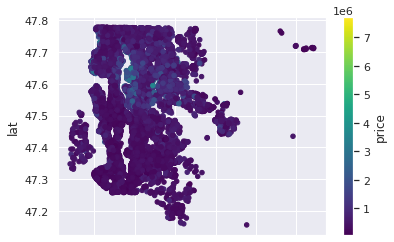

In [30]:
house_eda.plot(kind='scatter', x='long', y='lat', c='price', cmap='viridis')
plt.show()

We see that properties in the North appear to have higher values. Notably, they seem to be clustered in more urban areas. This suggests why latitude has a high correlation with price, as it lets the model know if the property is in a more urbanized area.

##### Do waterfront properties hold more value?

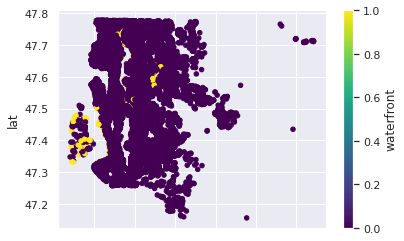

In [31]:
house_eda.plot(kind='scatter', x='long', y='lat', c='waterfront', cmap='viridis')
plt.show()

We note that waterfront properties in Vashon island do not hold significantly more value than other properties. 

## Data Preparation
With our EDA done, we will prepare our data to be used by our ML models.

### Remove Extreme Outliers
Since we do not care about our model's ability to predict extreme outlier properties, we will scrub them from out entire dataset. We mark extreme outliers based on [this](https://people.richland.edu/james/lecture/m170/ch03-pos.html) definition of an outlier: a value which lies more than 3 times the interquartile range below or above the lower and upper quartile. 

We also apply a log transformation when calculating outliers, to make the feature more normally distributed,

In [88]:
house_df_ = house_df.copy()

In [89]:
len(house_df_)

21613

In [90]:
def mark_extreme_outlier(df, var):
  col = df[var].apply(np.log)
  Q3 = col.quantile(0.75)
  Q1 = col.quantile(0.25)
  IQR = Q3 - Q1
  UpperFence = Q3 + 3 * IQR
  LowerFence = Q1 - 3 * IQR
  mask = (col > UpperFence) | (col < LowerFence)
  return mask.values
marked_outliers = [mark_extreme_outlier(house_df_, col) for col in ("bedrooms", "bathrooms", "sqft_lot", "sqft_lot15", "sqft_living", "sqft_living15", "price")]
house_df_["drop"] = np.logical_or.reduce(marked_outliers)

In [91]:
marked_outliers[3].sum()

443

In [92]:
house_df_ = house_df_[house_df_["drop"] == 0]
house_df_.reset_index(inplace=True)
house_df_.drop("drop", axis=1, inplace=True)

In [93]:
len(house_df_)

20803

After scrubbing our data to remove extreme outliers, we are left with 20803 rows remaining (810 rows scrubbed)

### Separate Target & Features

In [94]:
X, y = house_df.drop("price", axis = 1), house_df["price"]
X["date"] = pd.to_datetime(X["date"])

### Dropping Uninformative Columns
- We will drop zipcode, id since based on our eda, these columns have relatively little utility, and having the zipcode would greatly increase the dimensionality of our data due to the need to one hot encode the data.

In [95]:
X.drop(["zipcode", "id"], axis=1, inplace=True)

### Create Hold-Out Set
To evaluate our model, we will first split our data into two parts: a training set and an indepedent test set

We then peform cross validation on our training set to select our best model. Then, we evaluate the final model on the independent test set to obtain an unbiased estimate of model performance.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True,random_state = random_state)
X_train_dt, X_test_dt = X_train.copy(), X_test.copy() # we keep a copy of the data with date feature to experiment with later
X_train.drop(["date"], axis = 1, inplace=True)
X_test.drop(["date"], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Data Pre-processing Pipeline
For our inital pre-processing steps, we will attempt:


#### Scaling
- Since many of the numerical features are on different scales, we will perform feature scaling to standarize their values


In [97]:
data_preprocessing = Pipeline([
    ('Feature Scaling (Standardization)', StandardScaler())
])

## Modelling
We will now try out different models and select the best candidate models. This will be done on the training set using cross validation.

### Evaluation Function
To standardize the reporting of our model performance, we make use of a custom function which cross validates our model, and keeps a history of our model performance. As mentioned in the introduction, we will utlize MAE as our performance metric.

In [103]:
def evaluate_candidate_model(reg, X, y, metrics = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"], cv = KFold(n_splits = 5, shuffle = True, random_state=42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(reg).__name__
    single_metric = type(metrics) in { str, callable }
    scores = cross_validate(reg, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_neg_mean_absolute_error"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot["Standard Error of MAE"] = scores["test_neg_mean_absolute_error"].iloc[1] / np.sqrt(cv.get_n_splits())
    his_snapshot["Performance Gap"] = his_snapshot["train_neg_mean_absolute_error"] - his_snapshot["test_neg_mean_absolute_error"]
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    if return_learning_curve:
        lr = plot_learning_curve(reg, X, y, scoring = metrics[0], cv = cv)
    return scores, history, lr if return_learning_curve else None, best_estimator if return_estimator else None

### Baseline Model (Median Value Predictor)
We start by using a baseline model that predicts the median value (since the distribution is skewed, median is a more accurate measure of the average value of a house). This is to determine the baseline that our models have to beat.

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-219836.75171,-219836.36964,-0.42509,-0.42509,-371198.29271,-371908.69855
std,7153.45017,1788.34363,0.00680,0.00171,26586.23194,6847.54433


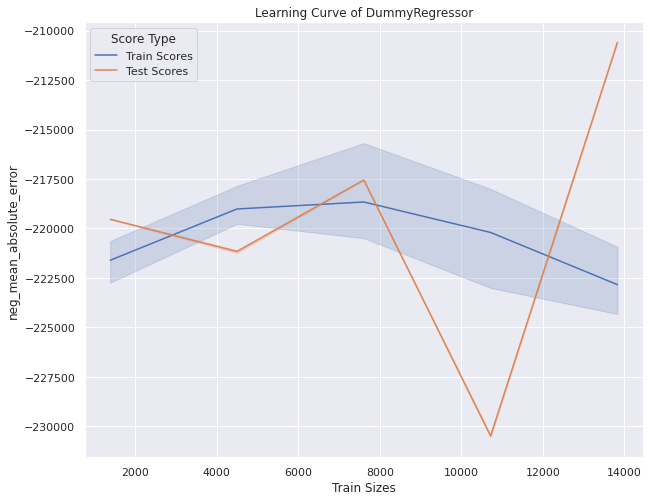

In [99]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', DummyRegressor(strategy='median'))
])

scores, history, lr, _ = evaluate_candidate_model(baseline, X_train, y_train, model_name="Baseline")
display(scores)

We see that a baseline model that predicts the median performs extremely poorly. It has a mean  absolute error of 219.8K USD, meaning it is typically off by a significant margin. This is much higher than the max margin of error we are allowing the model to have of 15%.

### Linear Regression
We then begin by attempting a simple linear regression model.

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-125678.16513,-125418.09144,-0.25505,-0.25481,-200111.40059,-199451.04019
std,2274.22681,1435.56265,0.00399,0.00273,14785.44355,3753.13319


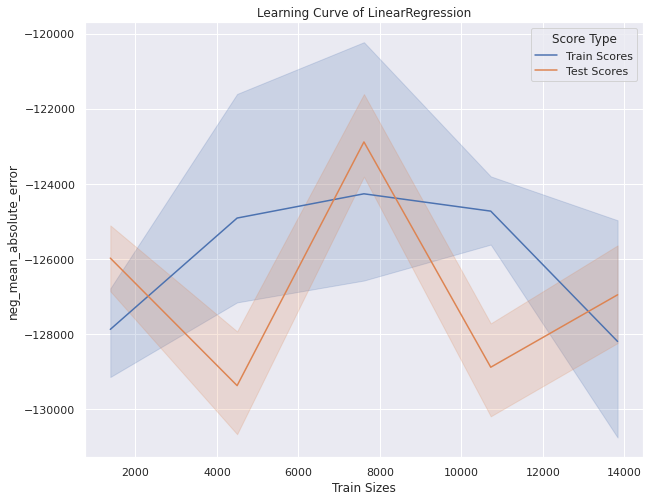

In [100]:
linreg = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', LinearRegression())
])

scores, history, lr, _ = evaluate_candidate_model(linreg, X_train, y_train, model_name="Linear Regression", history=history)
display(scores)

A basic linear regression model performs better than the baseline, having approximately half of the median absolute error of the baseline. We also see that the variance of the model appears to be small, as the difference between the training and cross validation scores is low. This suggests that the linear regression model does not require regularization. Unfortunately, it also seems that the model does suffer from a high bias, as it still performs poorly overall.

The learning curve also confirms that the model has a high bias.

### Random Forests
We then attempt a random forests model, which uses a ensemble of decision trees (which have inherently low bias for most problems), and implements bagging to smooth the variance of the decision trees.

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-70258.18010,-26422.00238,-0.13257,-0.05024,-129085.00633,-48711.22245
std,2884.00783,207.44951,0.00271,0.00023,12772.14181,773.88823


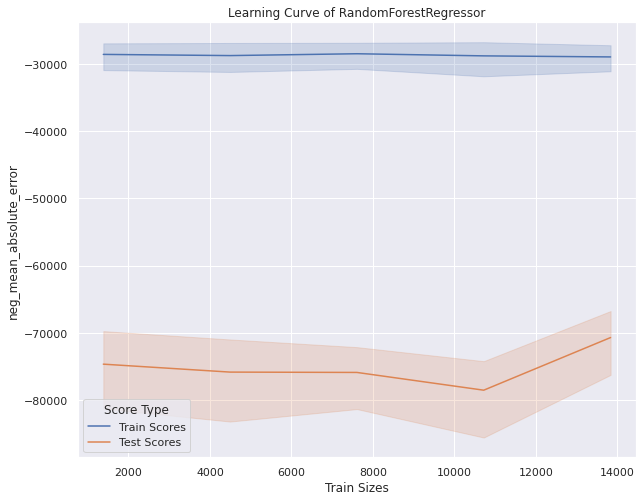

In [101]:
rf = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', RandomForestRegressor(random_state = random_state))
])

scores, history, lr, _ = evaluate_candidate_model(rf, X_train, y_train, model_name="Random Forest Regressor", history=history)
display(scores)

We see that a Random Forests model performs extremely well for our data, but as can be seen from the learning curve, still has a very high variance, causing to overfit the data heavily.

### Extra Trees
To solve the overfitting problem, we attempt using Extra Randomized Trees, which we hope will result in a model with lower variance.

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-70295.87101,-738.56089,-0.13398,-0.00237,-126558.55726,-8807.13720
std,1811.90995,56.18820,0.00253,0.00017,6147.31676,617.56371


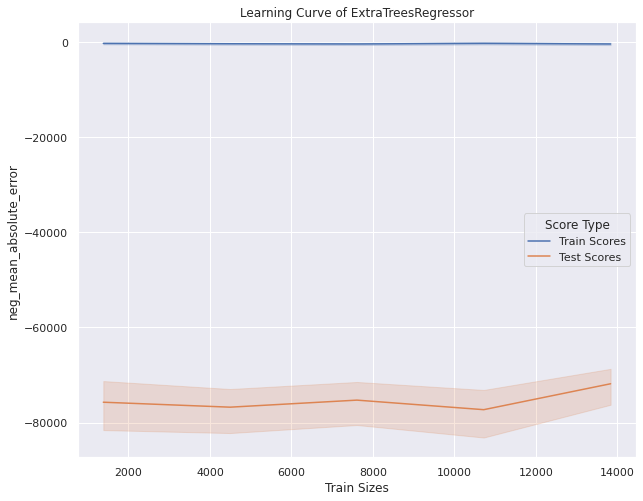

In [102]:
et = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', ExtraTreesRegressor(random_state = random_state))
])

scores, history, lr, _ = evaluate_candidate_model(et, X_train, y_train, model_name="Extra Trees Regressor", history=history)
display(scores)

Unfortunately, we see that extra trees has an even higher variance than the Random Forests model, while not offering a real change in performance. 

### Gradient Boosted Trees

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-78052.50530,-72871.15351,-0.15042,-0.14428,-131915.57563,-114269.00761
std,1634.04579,841.93308,0.00296,0.00144,2902.60691,1218.92884


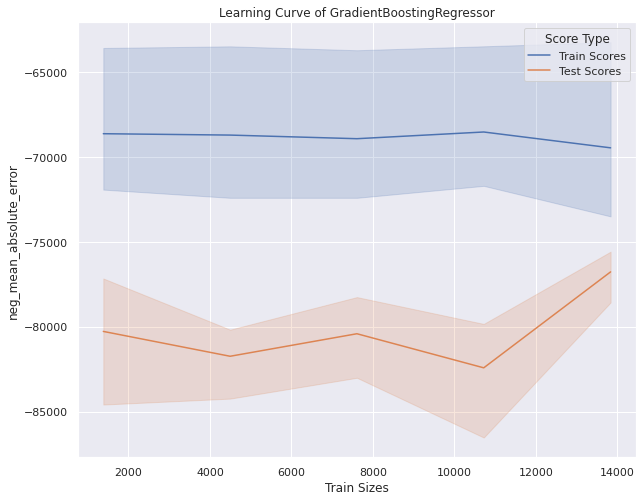

In [104]:
gbm = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', GradientBoostingRegressor(random_state = random_state))
])

scores, history, lr, _ = evaluate_candidate_model(gbm, X_train, y_train, model_name="Gradient Boosting Regressor", history=history)
display(scores)

The gradient booster does appear to have a higher bias than random forests, but it has a much lower variance, thus overfitting less. 

### Histogram Gradient Boosting
Finally, we attempt using a Histogram Based Gradient Boosting Models. This model performs a discretization process on our continouous variables by binning them. This not only should improve the speed of training, but should also be less affected by outliers, as they can simply be binned together with normal values.

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-67782.74564,-55458.45915,-0.12915,-0.11474,-124884.60485,-89151.22067
std,1964.93926,1020.02179,0.00250,0.00143,14300.55577,2255.26082


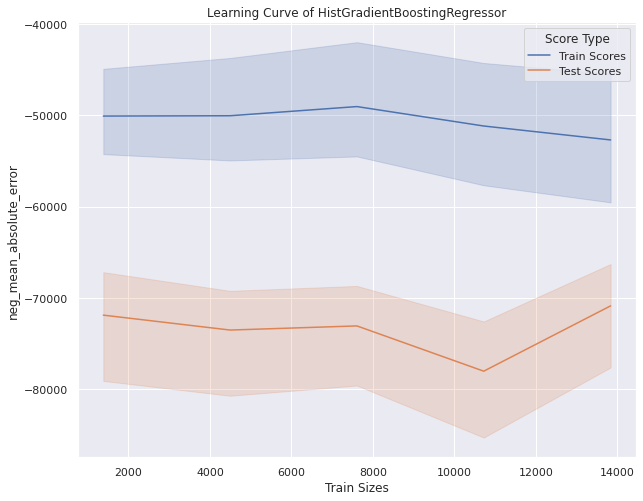

In [105]:
histgbm = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', HistGradientBoostingRegressor(random_state = random_state))
])

scores, history, lr, _ = evaluate_candidate_model(histgbm, X_train, y_train, model_name="Histogram Gradient Boosting Regressor", history=history)
display(scores)

The Histogram Based Gradient Booster performs the best thus far as it has the best CV MAE. Like the normal gradient booster, it seems to have a much lower variance than Random Forests. However, it does seem to overfit more than the gradient booster as there is a larger gap between the CV and training scores.

### Summary of Various Models (Basic Preprocessing)

In [106]:
baseline_history = history.copy()
baseline_history.sort_values("test_neg_mean_absolute_error", ascending=False)

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN


We observe that
- the Histogram Based Gradient booster seems to hit the sweet spot as it does not overfit as heavily as Random Forests, and has the best performance on cross validation
- In general, gradient boosting models seem the most suited to this problem.

## Model Improvement 
Our best models thus far appear to be the Histogram Gradient Booster and Random Forests

Both models show signs of overfitting (with random forests showing more signs of overfitting than Hist GBM). Hence, we attempt to reduce the variance of these learning algorithms.


### Feature Selection
We will start by attempting to reduce the number of features in our data. Our aim is to remove less powerful predictors from the data, to avoid our models overfitting to noise from less important features.

In [107]:
X_train.shape #  we start out with 17 cols

(17290, 17)

In [123]:
fs_hist = baseline_history.copy()

#### Recursive Feature Elimination
One method for feature selection is Recursive Feature Elimination. In this algorithm, we use the feature importance generated by a model like RandomForests or Linear Regression to decide on which features to removed. This method is faster than a greedy search as we do not have to try out all possible feature combinations, and is more powerful than a filter based feature selection method.

In [124]:
results = {}
for no_features in (16, 15, 14):
  reg = Pipeline([
      ('Data Preprocessing', data_preprocessing),
      ('Feature Selection', RFE(RandomForestRegressor(), n_features_to_select=no_features)),
      ('Model', RandomForestRegressor(random_state=random_state))
  ])
  scores, fs_hist, lr, results[f"RF (RFE on RF, {no_features}"] = evaluate_candidate_model(reg, X_train, y_train, model_name=f"RF (RFE on RF, {no_features})", history=fs_hist, return_estimator=True, return_learning_curve=False)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [125]:
for no_features in (16, 15, 14):
    reg = Pipeline([
        ('Data Preprocessing', data_preprocessing),
        ('Feature Selection', RFE(GradientBoostingRegressor(random_state=random_state), n_features_to_select=no_features)),
        ('Model', HistGradientBoostingRegressor(random_state=random_state))
    ])
    scores, fs_hist, lr, results[f"HistGBM (RFE on GBM), {no_features}"] = evaluate_candidate_model(reg, X_train, y_train, model_name=f"HistGradientBoostingRegressor (RFE on GBM, {no_features})", history=fs_hist, return_estimator=True, return_learning_curve=False)

For Hist GBM, we make use of the FI from a Gradient Boosting Model (HistGBM does not currently expose any feature importances). The idea behind using a GradientBoostingRegressor for FI scores instead of Random Forest is that the FI scores of a model are what features that type of model thinks is important, and may not be as applicable for other models, who may prefer other features. Hence, the FI of a gradient boosting model would be more relevant to HistGBM than FI of a bagging model like RF.

In [133]:
fs_hist.sort_values("test_neg_mean_absolute_error")

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
"RF (RFE on RF, 14",1283.416103,-70668.74784,-0.13363,-129675.02287,-26557.87019,-0.05060,-48755.33318,44110.87765
"RF (RFE on RF, 15",1282.329396,-70460.71534,-0.13291,-129873.90633,-26472.95130,-0.05033,-48849.18422,43987.76404
"RF (RFE on RF, 16",1324.106235,-70330.00691,-0.13272,-129671.28611,-26439.53834,-0.05025,-48729.63771,43890.46857
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
"HistGradientBoostingRegressor (RFE on GBM, 14",828.470202,-67930.92897,-0.12954,-124900.90647,-56136.18015,-0.11556,-90592.79526,11794.74882
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649


In [131]:
removed_features = {
    val : [feature for feature, support in zip(X_train.columns, results[val][-2].get_support()) if not support] for val in results.keys()
}

In [132]:
removed_features

{'HistGBM (RFE on GBM), 14': ['bedrooms', 'floors', 'yr_renovated'],
 'HistGBM (RFE on GBM), 15': ['bedrooms', 'floors'],
 'HistGBM (RFE on GBM), 16': ['floors'],
 'RF (RFE on RF, 14': ['floors', 'condition', 'yr_renovated'],
 'RF (RFE on RF, 15': ['floors', 'yr_renovated'],
 'RF (RFE on RF, 16': ['yr_renovated']}

```
{'HistGBM (RFE on GBM), 14': ['bedrooms', 'floors', 'yr_renovated'],
 'HistGBM (RFE on GBM), 15': ['bedrooms', 'floors'],
 'HistGBM (RFE on GBM), 16': ['floors'],
 'RF (RFE on RF), 14': ['floors', 'condition', 'yr_renovated'],
 'RF (RFE on RF), 15': ['floors', 'yr_renovated'],
 'RF (RFE on RF), 16': ['yr_renovated']}
 ```
Based on our experiments, 15 features (removing 1 feature) seems to be the sweet spot for the number of features to remove for the Histogram Based Gradient Booster. The features to be removed are the number of bedrooms and number of floors of the house. In contrast, Random Forests feels that it is simply enough to remove the year renovated feature. 

### Regularization
HistGradientBoostingRegressor supports a form of L2 Regularization. However, by default, this is disabled. Applying L2 Regularization could help further reduce the variance of our models, as it would penalize the complexity of the model.

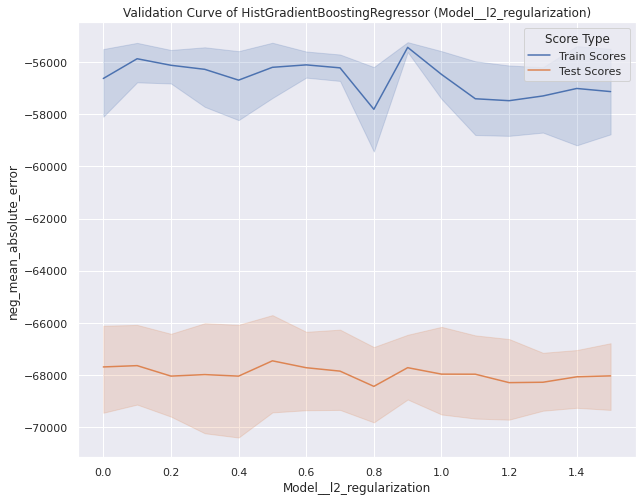

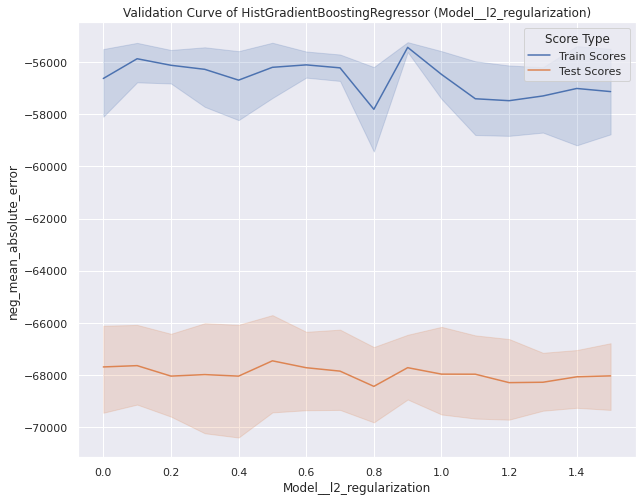

In [143]:
reg = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', HistGradientBoostingRegressor(random_state=random_state))
])
plot_validation_curve(reg, X=X_train, y=y_train, param_name="Model__l2_regularization", param_range=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5])

From looking at the validation curve, it appears evident that regularization does not appear to help our model performance on the cross validation set much. 

### Transforming the Target Variable
From our EDA, we found that price follows a log-normal distribution. We attempt to apply a log transformation on our target to see if it improves the performance of our models.

In [145]:
target_log_hist = baseline_history.copy()

In [146]:
models = [HistGradientBoostingRegressor(random_state=random_state), RandomForestRegressor(random_state=random_state)]
for model in tqdm(models):
    reg = Pipeline([
        ('Feature Scaling', data_preprocessing),
        ('Model', model)
    ])
    transformed_reg = TransformedTargetRegressor(reg, func=np.log, inverse_func=np.exp)
    model_name = type(model).__name__
    scores, target_log_hist, lr, _ = evaluate_candidate_model(transformed_reg, X_train, y_train, model_name=f"{model_name} (Log Transform on Price)", history=target_log_hist, return_learning_curve = False)
    print(f"{model_name} (Log Transform on Price)")
    display(scores)
display(target_log_hist)

  0%|          | 0/2 [00:00<?, ?it/s]

HistGradientBoostingRegressor (Log Transform on Price)


,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-65494.21380,-55211.77610,-0.12195,-0.10524,-121641.74211,-95563.51158
std,2755.99333,258.08118,0.00247,0.00016,17912.25560,1021.63431


 50%|█████     | 1/2 [00:03<00:03,  3.72s/it]

RandomForestRegressor (Log Transform on Price)


,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-70632.25938,-27036.47323,-0.12928,-0.04811,-133875.87652,-54941.97495
std,3348.36733,327.84312,0.00310,0.00028,15204.12803,1582.33825


100%|██████████| 2/2 [00:49<00:00, 24.74s/it]


,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649
HistGradientBoostingRegressor (Log Transform on Price),1232.517686,-65494.21380,-0.12195,-121641.74211,-55211.77610,-0.10524,-95563.51158,10282.43770
RandomForestRegressor (Log Transform on Price),1497.435393,-70632.25938,-0.12928,-133875.87652,-27036.47323,-0.04811,-54941.97495,43595.78615


In [148]:
target_log_hist.nlargest(5, "test_neg_mean_absolute_error")

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
HistGradientBoostingRegressor (Log Transform on Price),1232.517686,-65494.21380,-0.12195,-121641.74211,-55211.77610,-0.10524,-95563.51158,10282.43770
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
RandomForestRegressor (Log Transform on Price),1497.435393,-70632.25938,-0.12928,-133875.87652,-27036.47323,-0.04811,-54941.97495,43595.78615


We see that while performing a log transform works well for the Histogram Gradient Boosting Regressor, and has even reduced the variance of the model (the gap in training and cv performance has been reduced), it does not help Random Forests, as the score for RF has not significantly changed.

### Age as a Feature
To attempt other methods of improving the models, I try and make use of the date, and perform feature engineering to extract the age of the houses to see if it works out as a predictor.

In [149]:
time_hist = baseline_history.copy()

In [150]:
class HouseAgeCalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        X_ = pd.DataFrame(X, columns=X_train_dt.columns)
        X_["Age"] = X_["date"].dt.year - X_["yr_built"]
        X_ = X_.drop(["date"], axis = 1)
        return X_ 

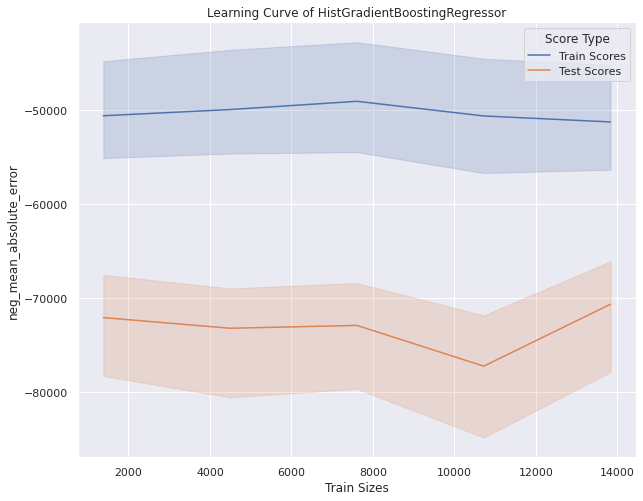

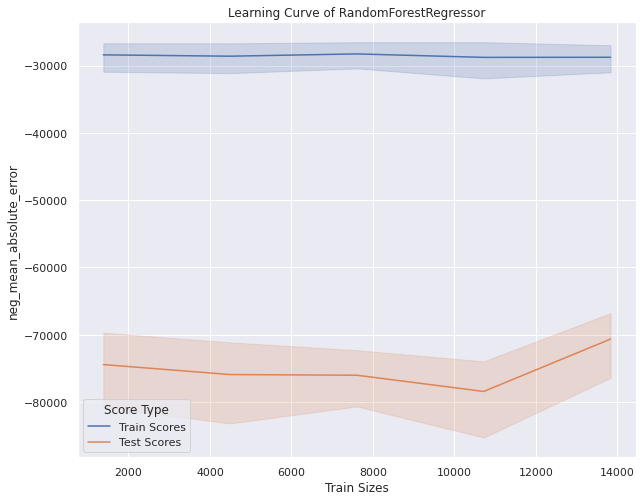

In [151]:
models = [HistGradientBoostingRegressor(random_state=random_state), RandomForestRegressor(random_state = random_state)]
for model in models:
  reg = Pipeline([
      ('Age of House', HouseAgeCalculator()),
      ('Data Preprocessing', data_preprocessing),
      ('Model', model)
  ])
  model_name = type(model).__name__
  scores, time_hist, lr, _ = evaluate_candidate_model(reg, X_train_dt, y_train, model_name=f"{model_name} (Age as Feature)", history=time_hist, return_learning_curve = True)

In [152]:
time_hist.sort_values("test_neg_mean_absolute_error")

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
RandomForestRegressor (Age as Feature),1273.138670,-70233.08064,-0.13254,-129662.79994,-26186.17119,-0.04949,-48265.46086,44046.90945
HistGradientBoostingRegressor (Age as Feature),849.364827,-67794.21835,-0.12927,-124998.96830,-55330.41368,-0.11454,-88730.43410,12463.80467
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649


As we can see, adding age as a feature does not appear to help Hist Gradient Booster, but does result in a slight improvement of the MAE for Random Forests.

### Comparing Feature Scaling Methods
We compare various methods of feature scaling, to see which scaler has the best impact on the model. We will also look at what happens if no feature scaling is done at all.

In [157]:
scaler_hist = baseline_history.copy()

In [158]:
# No Scaling Performed For Comparison
no_scaling = [HistGradientBoostingRegressor(random_state=random_state), RandomForestRegressor(random_state=random_state)]
for model in no_scaling:
  model_name = type(model).__name__
  scores, scaler_hist, lr, _ = evaluate_candidate_model(model, X_train, y_train, model_name=f"{model_name} (No Scaling)", history=scaler_hist, return_learning_curve = False)

In [159]:

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), QuantileTransformer()]
models = [HistGradientBoostingRegressor(random_state=random_state), RandomForestRegressor(random_state=random_state)]
for model in models:
  for scaler in scalers:
    reg = Pipeline([
                    ("Scaler", scaler),
                    ("Model", model)
    ])
    scores, scaler_hist, lr, _ = evaluate_candidate_model(reg, X_train, y_train, model_name=f"{type(model).__name__} ({type(scaler).__name__})", history=scaler_hist, return_learning_curve = False)

In [160]:
scaler_hist.sort_values("test_neg_mean_absolute_error")

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
RandomForestRegressor (QuantileTransformer),1264.832442,-70278.75722,-0.13268,-129075.04581,-26448.05045,-0.05030,-48758.81679,43830.70677
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
RandomForestRegressor (StandardScaler),1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,43836.17772
RandomForestRegressor (MinMaxScaler),1298.091475,-70246.91904,-0.13255,-129173.99907,-26424.78061,-0.05024,-48698.34435,43822.13843
RandomForestRegressor (RobustScaler),1296.237578,-70233.42883,-0.13252,-129089.78521,-26419.47193,-0.05024,-48681.40198,43813.95690
RandomForestRegressor (No Scaling),1293.858214,-70226.83152,-0.13250,-129048.75419,-26421.15350,-0.05023,-48687.43196,43805.67802


We note that in this scenario, there are effectively no significant differences between the feature scaling methods, with the possible exception to the Quantile Transformer for Random Forests which seems to cause a drop in the performance of the model.

Given this, we will simply retain the Standardization we were already doing.

### Hyperparameter Tuning

To further improve our models, we will perform Hyperparameter Tuning. To reduce the amount of time taken to find an optimal model, we perform a random search instead of a grid search.

We will make use of the best methods for model improvement found for each model thus far


In [186]:
hyperparam_hist = baseline_history.copy()

In [185]:
# param_grid = {
#     "Model__regressor__loss" : ["least_squares", "least_absolute_deviation"],
#     "Model__regressor__learning_rate" : [0.1, 0.15, 0.05, 0.2, 0.3 ,1],
#     "Model__regressor__max_depth" : [None, 4, 6, 8],
#     "Model__regressor__min_samples_leaf" : [15, 20, 30, 50, 100],
#     "Model__regressor__l2_regularization" : [0, 0.5, 0.8, 1, 1.2, 1.5],
#     "Model__regressor__max_bins" : [255, 200, 150]
# }
reg_histgbm = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(HistGradientBoostingRegressor(random_state=random_state), func=np.log, inverse_func=np.exp))
])

reg_rf = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(RandomForestRegressor(random_state=random_state), func=np.log, inverse_func=np.exp))
])
# grid_search  = HalvingGridSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, resource="Model__regressor__max_iter", min_resources=10, max_resources=250)
features_rf = [feature for feature in X_train.columns if feature !="yr_renovated"]
features_gbm = [feature for feature in X_train.columns if feature not in {"floors", "bedrooms"}]

In [184]:
X_train_dt[features_rf].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 6325 to 15795
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           17290 non-null  datetime64[ns]
 1   bedrooms       17290 non-null  int64         
 2   bathrooms      17290 non-null  float64       
 3   sqft_living    17290 non-null  int64         
 4   sqft_lot       17290 non-null  int64         
 5   floors         17290 non-null  float64       
 6   waterfront     17290 non-null  int64         
 7   view           17290 non-null  int64         
 8   condition      17290 non-null  int64         
 9   grade          17290 non-null  int64         
 10  sqft_above     17290 non-null  int64         
 11  sqft_basement  17290 non-null  int64         
 12  yr_built       17290 non-null  int64         
 13  lat            17290 non-null  float64       
 14  long           17290 non-null  float64       
 15  sqft_living15  1

In [187]:
scores, hyperparam_hist, lr, _ = evaluate_candidate_model(reg_histgbm, X_train[features_gbm], y_train, model_name="HistGradientBoostingRegressor (Hyperparameter Search Baseline)", history=hyperparam_hist, return_learning_curve = False)
scores, hyperparam_hist, lr, _ = evaluate_candidate_model(reg_rf, X_train[features_rf], y_train, model_name="RandomForestRegressor (Hyperparameter Search Baseline)", history=hyperparam_hist, return_learning_curve = False)

In [202]:
param_grid = {
    "Model__regressor__max_depth" : [None, 7, 8, 9, 10, 11, 12, 13, 14],
    "Model__regressor__min_samples_leaf" : np.linspace(5, 100, 10, dtype=int),
    "Model__regressor__l2_regularization" : np.linspace(0, 2),
}
hist_random_search = RandomizedSearchCV(reg_histgbm, param_grid, scoring="neg_mean_absolute_error", n_iter=120, n_jobs=-1)

In [203]:
scores, hyperparam_hist, lr, best_estimator_gbm = evaluate_candidate_model(hist_random_search, X_train[features_gbm], y_train, model_name="HistGradientBoostingRegressor (Hyperparameter Search - Random)", history=hyperparam_hist, return_estimator=True, return_learning_curve = False)
scores

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-65362.34637,-55930.57780,-0.12201,-0.10635,-121612.66601,-99838.98876
std,2464.96922,505.67908,0.00222,0.00084,16542.62336,2016.26750


In [204]:
best_estimator_gbm.best_params_

{'Model__regressor__l2_regularization': 0.12244897959183673,
 'Model__regressor__max_depth': 13,
 'Model__regressor__min_samples_leaf': 26}

```
{'Model__regressor__l2_regularization': 0.12244897959183673,
 'Model__regressor__max_depth': 13,
 'Model__regressor__min_samples_leaf': 26}
 ```

In [210]:
param_grid = {
    "Model__regressor__n_estimators" : [100, 150, 200, 250, 300],
    "Model__regressor__max_depth" : [None, 4, 5, 6, 7, 8, 9, 10, 15],
    "Model__regressor__min_samples_leaf" : [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}
rf_random_search = RandomizedSearchCV(reg_rf, param_grid, scoring="neg_mean_absolute_error", n_iter=120, n_jobs=-1)
# grid_search  = RandomSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, resource="Model__regressor__max_iter", min_resources=10, max_resources=250)

In [211]:
scores, hyperparam_hist, lr, best_estimator_rf = evaluate_candidate_model(rf_random_search, X_train[features_rf], y_train, model_name="RandomForestRegressor (Hyperparameter Search - Random)", history=hyperparam_hist, return_estimator=True, return_learning_curve = False)

In [212]:
print(best_estimator_rf.best_params_)

{'Model__regressor__n_estimators': 300, 'Model__regressor__min_samples_leaf': 5, 'Model__regressor__max_features': None, 'Model__regressor__max_depth': None}


In [240]:
hyperparam_hist.sort_values("test_neg_mean_absolute_error")

,Standard Error of MAE,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,Performance Gap
Baseline,3199.120171,-219836.75171,-0.42509,-371198.29271,-219836.36964,-0.42509,-371908.69855,NaN
Linear Regression,1017.065149,-125678.16513,-0.25505,-200111.40059,-125418.09144,-0.25481,-199451.04019,NaN
Gradient Boosting Regressor,730.767493,-78052.50530,-0.15042,-131915.57563,-72871.15351,-0.14428,-114269.00761,5181.35179
RandomForestRegressor (Hyperparameter Search Baseline),1442.040659,-70709.30474,-0.12951,-133754.00916,-27034.69376,-0.04814,-54964.06789,43674.61098
RandomForestRegressor (Hyperparameter Search - Random),1445.564823,-70362.07030,-0.12878,-133601.14026,-26771.98895,-0.04759,-54415.62396,43590.08135
Extra Trees Regressor,810.310763,-70295.87101,-0.13398,-126558.55726,-738.56089,-0.00237,-8807.13720,NaN
Random Forest Regressor,1289.767511,-70258.18010,-0.13257,-129085.00633,-26422.00238,-0.05024,-48711.22245,NaN
Histogram Gradient Boosting Regressor,878.747551,-67782.74564,-0.12915,-124884.60485,-55458.45915,-0.11474,-89151.22067,12324.28649
HistGradientBoostingRegressor (Hyperparameter Search Baseline),1209.591478,-65410.38869,-0.12190,-122021.17180,-55326.82481,-0.10537,-95999.38095,10083.56388
HistGradientBoostingRegressor (Hyperparameter Search - Random),1102.367748,-65362.34637,-0.12201,-121612.66601,-55930.57780,-0.10635,-99838.98876,9431.76857


After hyperparameter tuning, we find that the tuned HistGradientBoostingRegressor performs the best, with a cross validated MAE of 65362. While tuning Random Forests does slightly improve it's performance, it is still unable to match HistGradientBoostingRegressor.

## Final Model
After hyperparameter tuning, we have found the HistGradientBoostingRegressor to be our top performing model. Hence, we will select it and evaluate it on an independent test set to ensure it is able to generalize to new training examples.


In [214]:
reg = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(HistGradientBoostingRegressor(min_samples_leaf=26, l2_regularization= 0.12244897959183673, max_depth=13), func=np.log, inverse_func=np.exp))
])

In [215]:
reg.fit(X_train[features_gbm], y_train)

Pipeline(steps=[('Data Preprocessing', StandardScaler()),
                ('Model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=HistGradientBoostingRegressor(l2_regularization=0.12244897959183673,
                                                                                    max_depth=13,
                                                                                    min_samples_leaf=26)))])

## Model Evaluation
We will now evaluate the performance of our final model. 

In [216]:
y_pred = reg.predict(X_test[features_gbm])
y_pred_train = reg.predict(X_train[features_gbm])
mae_scores, mape_scores, rmse_scores, adj_rsq_scores = [], [], [], []
for (prediction, actual) in ((y_pred, y_test), (y_pred_train, y_train)):
  mae_scores.append(mean_absolute_error(actual, prediction))
  mape_scores.append(mean_absolute_percentage_error(actual, prediction))
  rmse_scores.append(np.sqrt(mean_squared_error(actual, prediction)))
  r_sq = r2_score(actual, prediction)
  adj_rsq_scores.append(1 - (1-r_sq)*(len(actual)-1)/(len(actual)-len(features)-1))   

final_model_scores = pd.DataFrame({
    "MAE" : mae_scores,
    "MAPE" : mape_scores,
    "RMSE" : rmse_scores,
    "Adjusted R Squared" : adj_rsq_scores
}, index=["Test", "Train"])
display(final_model_scores)

,MAE,MAPE,RMSE,Adjusted R Squared
Test,68252.057712,0.122283,123456.257239,0.898807
Train,56561.786375,0.107336,100904.196607,0.921996


From evaluating our final model on the hold out test scores we note that our model does overfit, however, our model still performs quite decently. 

### Residual Plot
To understand the type of errors our model is making, we create a residual plot.

In [217]:
residuals = y_test - y_pred

In [221]:
np.mean(residuals)

9023.04134637273

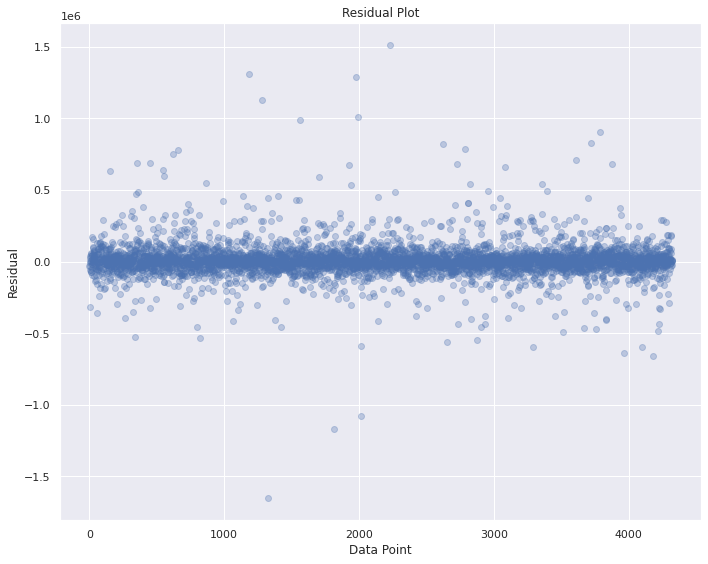

In [220]:
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
ax.scatter(x=range(len(residuals)), y=residuals, alpha=.3)
ax.set_title("Residual Plot")
ax.set_ylabel("Residual")
ax.set_xlabel("Data Point")
fig.show()

We observe from the residual plot, that the model has the tendency to underpredict the value of the house. This can be shown by the fact that the mean of the residuals is positive (9023), meaning an underprediction.

### Feature Importances
Since HistGradientBoostingRegressor does not yet expose it's feature importances, we can make use of permutation importance to determine which features are most useful to the model.

Permutation Importances works by randomly shuffling values in a feature, effectively making that feature become random noise. Then it measures the decrease in the score (in this case, MAE) of the model. The idea is that if a feature is more important, losing that feature will more greatly impact the MAE. Hence, by running this process repeatedly over all the features, we can generate an importance score for each feature.

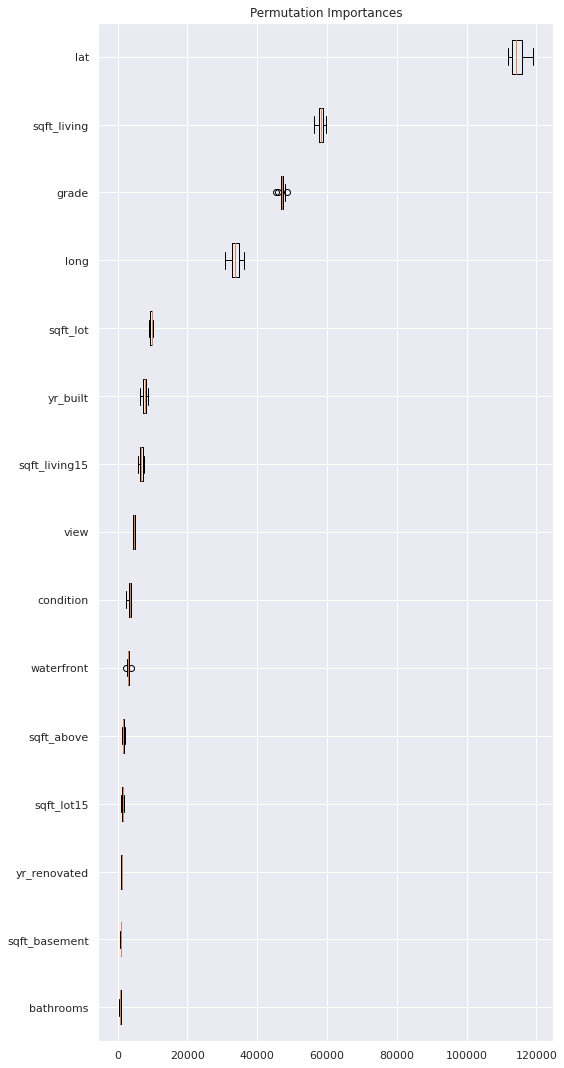

In [223]:
importances = permutation_importance(reg, X_test[features_gbm], y_test, n_repeats = 15, random_state = 42, n_jobs = -1, scoring="neg_mean_absolute_error")
sorted_idx = importances.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(8, 15), tight_layout=True)
ax.boxplot(importances.importances[sorted_idx].T, vert=False, labels=X_test[features_gbm].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.show()

In [260]:
len(y_test)

4323

We see that the top five most important features for the model are:

1.   Latitude
2.   Sqft_Living
3. Grade
4. Long
5. Lot Size
6. Year Built



## Conclusion
Overall, the final model is able to accomplish our initial objective, as it has shown to be a reasonably effective model for predicting housing prices. 

Furthermore, the final model's MAPE is less than 15% (the max margin of error according to UK Case Law, which while not exactly the same as MAPE, can be reasonably compared to it since MAPE measures the average error in percentage), meaning that while it may not completely replace an experienced real estate agent, it can still be a useful tool for getting a rough gauge at the valuation of a residential property.